In [1]:
import aster_processing_fn
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import xarray as xr
import rioxarray
import numpy as np
import scipy.stats as stats
from pyspectral.blackbody import blackbody_rad2temp
from pyspectral.blackbody import planck
import pandas as pd
import geopandas as gpd

In [2]:
#%matplotlib widget
%matplotlib inline

SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
# Identify TIFF files
airborne_tif = './images/YOSEMITE_IR_PLANE_2017Apr21_mosaicked_9_calCam.tif'
aster_tif = './images/AST_L1T_00304212017185107_20170422082541_26960_ImageData14.tif'

In [4]:
# Read in ASTER and convert to brightness temperature using xarray and aster_processing_fn
aster_src = xr.open_rasterio(aster_tif)
aster_band = 14
aster_rad = aster_processing_fn.tir_dn2rad(aster_src, aster_band)
aster_tb = aster_processing_fn.tir_rad2tb(aster_rad, aster_band)
# Convert to degC
aster_tb_degC = aster_tb-273.15
aster_tb_degC.rio.set_crs(aster_src.crs)

# Read in Airborne
air_tb = xr.open_rasterio(airborne_tif)
air_tb_K = air_tb+273.15

C:\Users\CALIR\Anaconda3\envs\uwgda2021\lib\site-packages\xarray\core\computation.py:724: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


In [5]:
def tb_to_rad(temps,wl):
    c1 = 1.191042e8
    c2 = 1.4387752e4
    rads = c1 / (wl**5 * (np.exp(c2/(wl*temps))-1))
    return rads

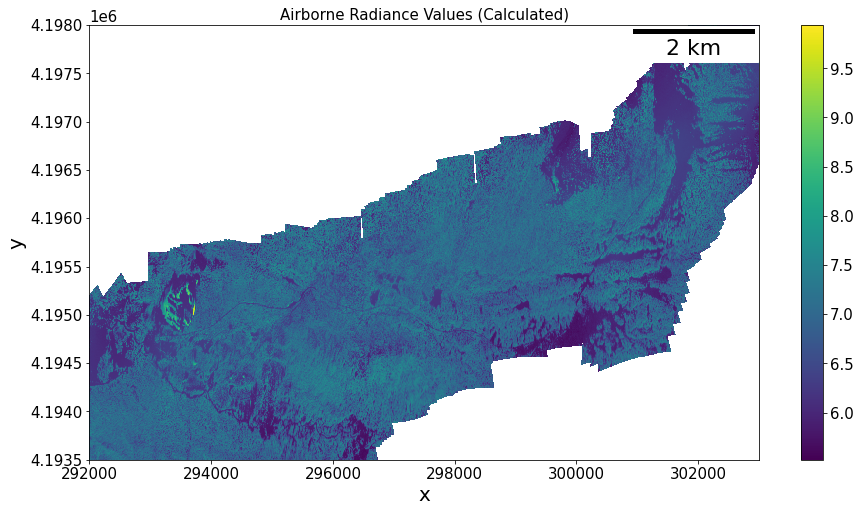

In [6]:
#air_rad_numpy = planck(0.000011, air_tb_K, wavelength=True)
#air_rad = xr.DataArray(air_rad_numpy.values, air_tb.coords)
#air_rad = air_rad.rio.set_crs(air_tb.crs)

air_rad = tb_to_rad(air_tb_K,11)
air_rad = air_rad.rio.set_crs(air_tb.crs)

f, ax = plt.subplots(figsize=(15,8))
air_rad.plot()
ax.add_artist(ScaleBar(1.0))
ax.set_title('Airborne Radiance Values (Calculated)');

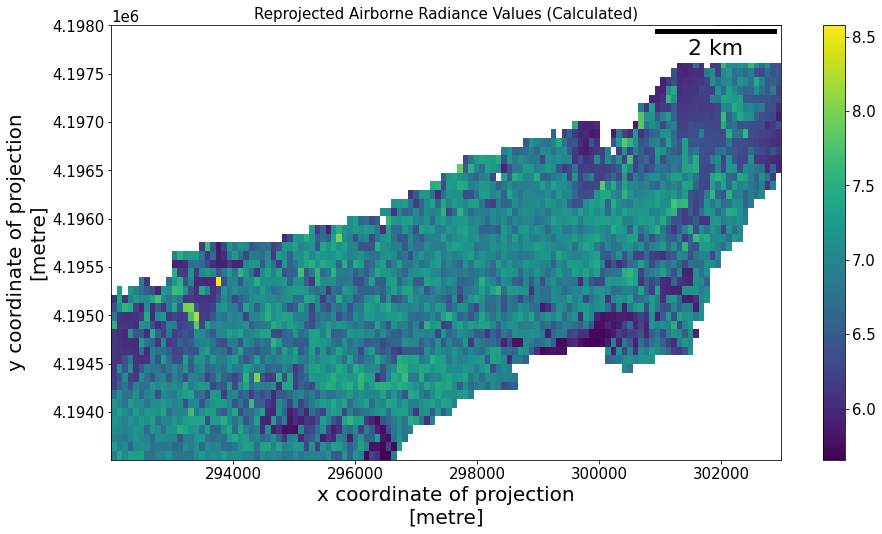

In [7]:
air_rad_repr = air_rad.rio.reproject_match(aster_src)

air_rad_repr = air_rad_repr.where(air_rad_repr != air_rad_repr.attrs['_FillValue'],drop=True)

f, ax = plt.subplots(figsize=(15,8))
air_rad_repr.plot()
ax.add_artist(ScaleBar(1.0))
ax.set_title('Reprojected Airborne Radiance Values (Calculated)');

In [8]:
def rad_to_tb(rads,wl):
    c1 = 1.191042e8
    c2 = 1.4387752e4
    temps = c2 / (wl * (np.log(c1/(wl**5 * rads)+1)))
    return temps

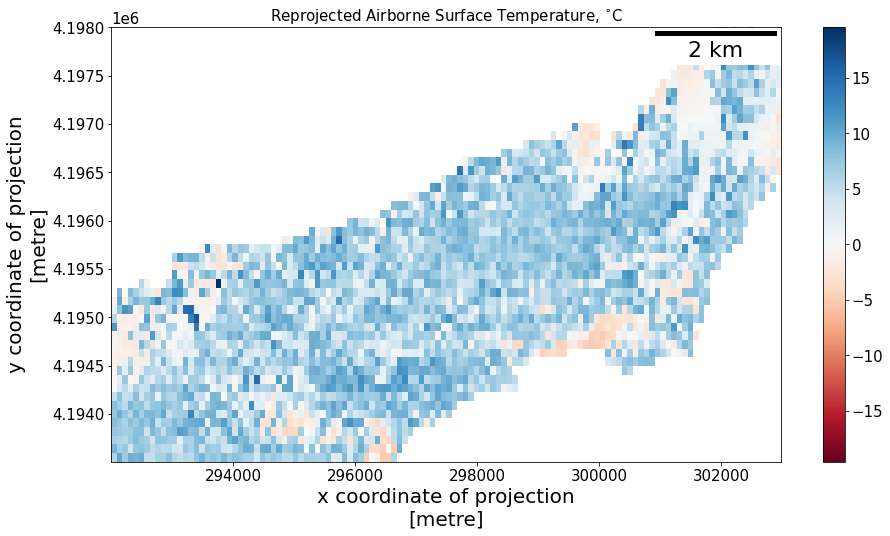

In [9]:
# Convert everything back
air_tb_K_repr = rad_to_tb(air_rad_repr, 11)
air_tb_repr = air_tb_K_repr - 273.15

f, ax = plt.subplots(figsize=(15,8))
air_tb_repr.plot(cmap='RdBu')
ax.add_artist(ScaleBar(1.0))
ax.set_title('Reprojected Airborne Surface Temperature, $^{\circ}$C');

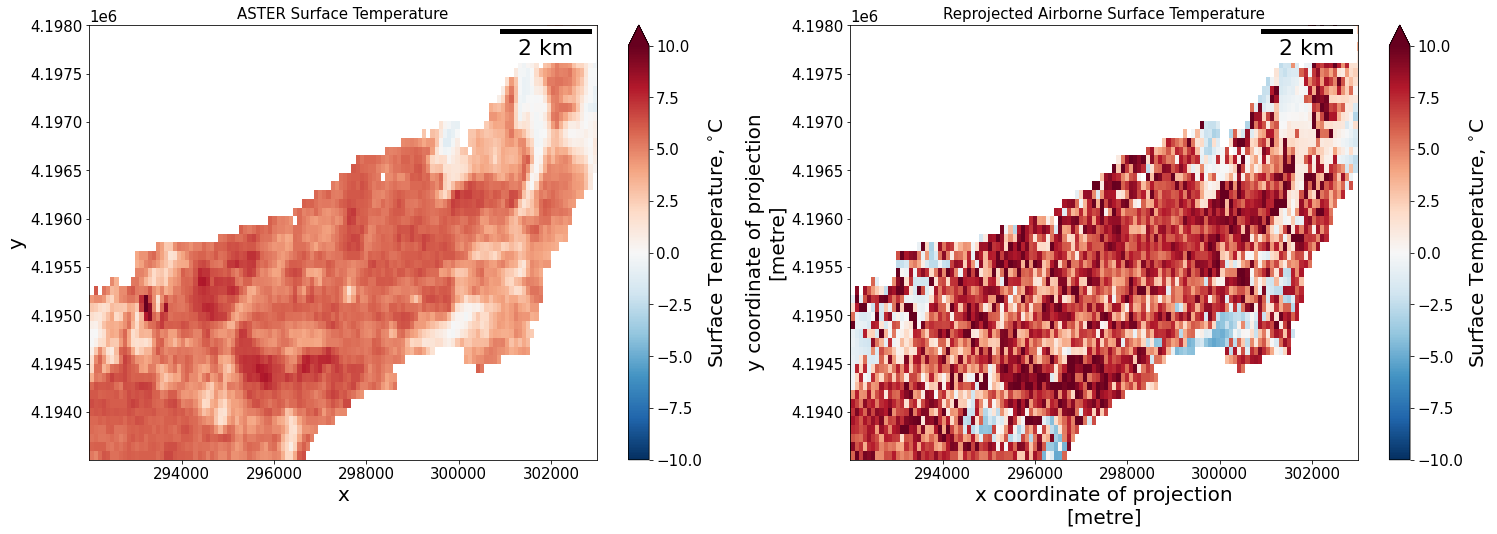

In [10]:
# Mask ASTER to study area
aster_tb_masked = aster_tb_degC.where(~np.isnan(air_tb_repr),drop=True)

# Plot both datasets
f, ax = plt.subplots(1,2,figsize=(25,8))

aster_tb_masked.plot(cmap='RdBu_r', cbar_kwargs={'label': 'Surface Temperature, $^{\circ}$C'},vmin=-10,vmax=10, ax=ax[0])
ax[0].add_artist(ScaleBar(1.0))
ax[0].set_title('ASTER Surface Temperature')

air_tb_repr.plot(cmap='RdBu_r', cbar_kwargs={'label': 'Surface Temperature, $^{\circ}$C'},vmin=-10,vmax=10,ax=ax[1])
ax[1].add_artist(ScaleBar(1.0))
ax[1].set_title('Reprojected Airborne Surface Temperature');

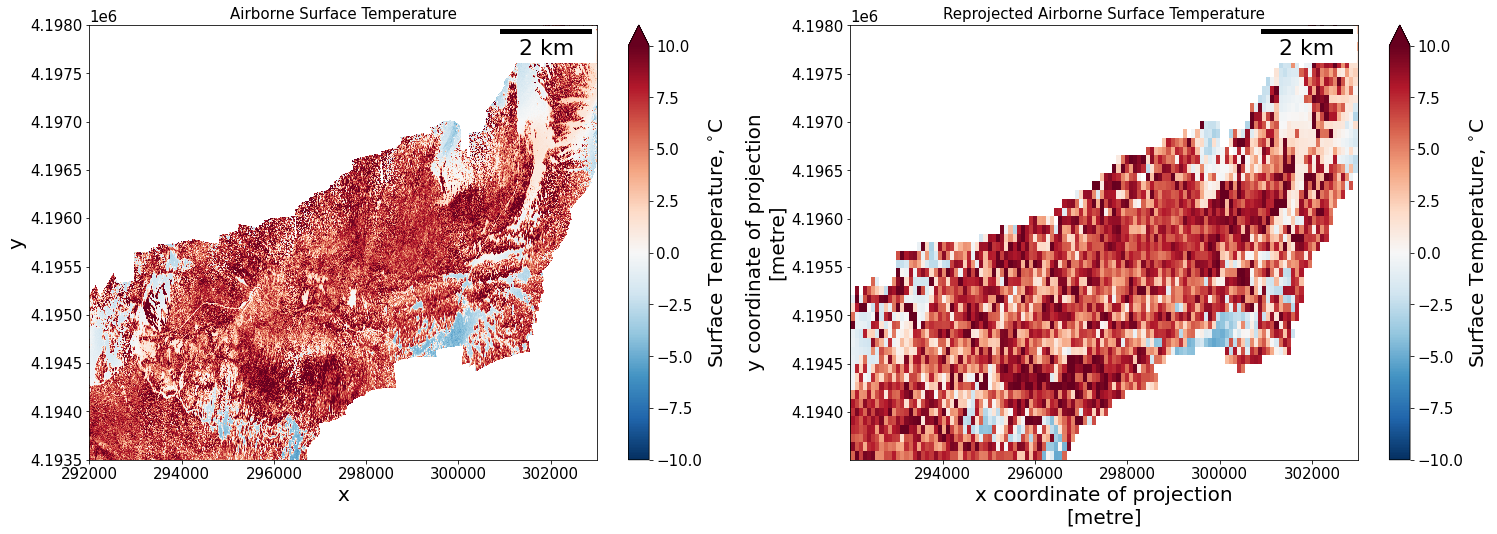

In [11]:
# Mask ASTER to study area
aster_tb_masked = aster_tb_degC.where(~np.isnan(air_tb_repr),drop=True)

# Plot both datasets
f, ax = plt.subplots(1,2,figsize=(25,8))

air_tb.plot(cmap='RdBu_r', cbar_kwargs={'label': 'Surface Temperature, $^{\circ}$C'},vmin=-10,vmax=10, ax=ax[0])
ax[0].add_artist(ScaleBar(1.0))
ax[0].set_title('Airborne Surface Temperature')

air_tb_repr.plot(cmap='RdBu_r', cbar_kwargs={'label': 'Surface Temperature, $^{\circ}$C'},vmin=-10,vmax=10,ax=ax[1])
ax[1].add_artist(ScaleBar(1.0))
ax[1].set_title('Reprojected Airborne Surface Temperature');

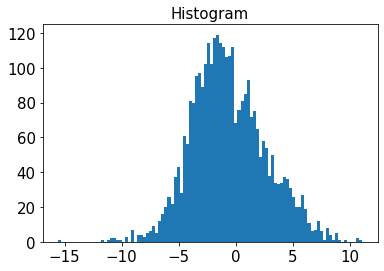

In [12]:
diff = aster_tb_masked - air_tb_repr
diff.plot.hist(bins=100);

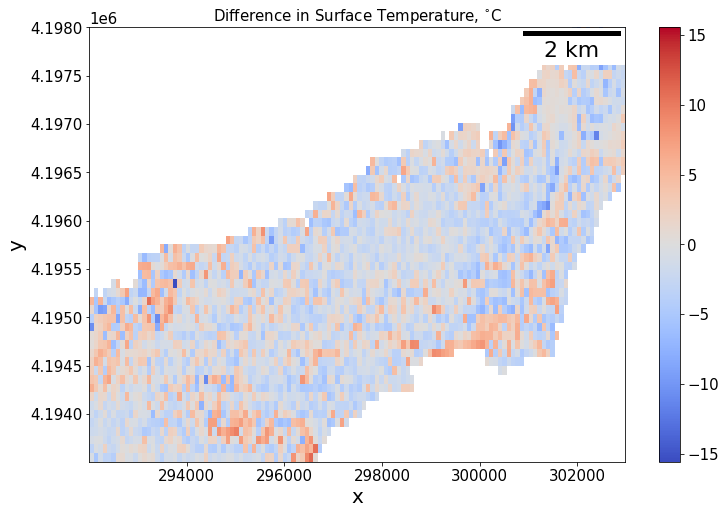

In [13]:
f, ax = plt.subplots(figsize=(12,8))
diff.plot(cmap='coolwarm')
ax.add_artist(ScaleBar(1.0))
ax.set_title('Difference in Surface Temperature, $^{\circ}$C');

In [14]:
# Calculate statistics of difference map
mean_diff = diff.mean().item(0)
median_diff = diff.median().item(0)
std_diff = diff.std().item(0)
max_diff = abs(diff).max().item(0)

print('Mean Difference = ', np.round(mean_diff,3))
print('Median Difference = ', np.round(median_diff,3))
print('Standard Devation of Differences = ', np.round(std_diff,3))
print('Maximum Difference = ', np.round(max_diff,3))

Mean Difference =  -0.612
Median Difference =  -0.926
Standard Devation of Differences =  3.234
Maximum Difference =  15.588


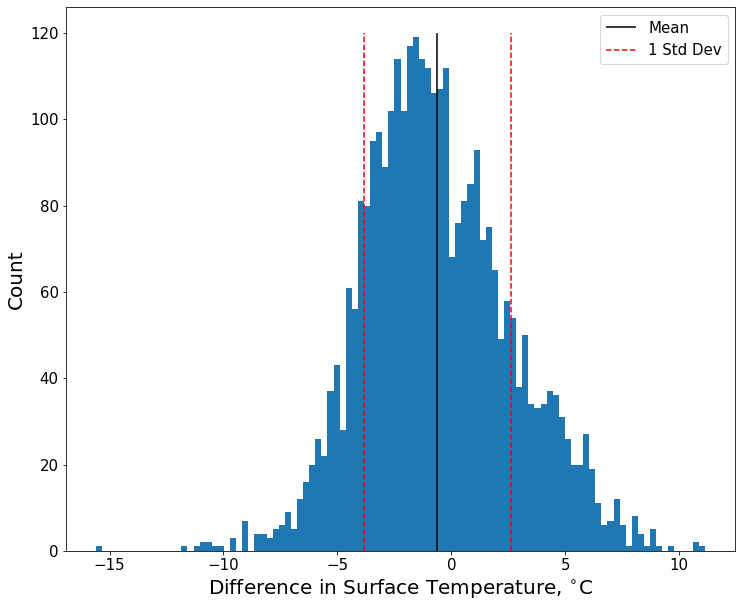

In [15]:
# Plot histogram of differences
f, ax = plt.subplots(figsize=(12,10))

plt.hist(diff.values.ravel(),bins=100)

# Plot vline at mean
ax.vlines(mean_diff, ymin=0, ymax=120, color='k', label='Mean')

# Plot vline at +- 1stdev
x_stdev = [mean_diff+std_diff, mean_diff-std_diff]
ax.vlines(x_stdev, ymin=0, ymax=120, color='r', linestyles='dashed', label='1 Std Dev')

plt.legend()

ax.set_xlabel('Difference in Surface Temperature, $^{\circ}$C')
ax.set_ylabel('Count');

In [16]:
# Identify red and near infrared images
red_path = './images/AST_L1T_00304212017185107_20170422082541_26960_ImageData2.tif'
nir_path = './images/AST_L1T_00304212017185107_20170422082541_26960_ImageData3N.tif'

In [17]:
# Pull red, nir and mask
red_src = xr.open_rasterio(red_path)
nir_src = xr.open_rasterio(nir_path)

red_m = red_src.where(~np.isnan(air_tb_repr),drop=True)
nir_m = nir_src.where(~np.isnan(air_tb_repr),drop=True)

In [18]:
# Calculate NDVI
NDVI = (nir_m-red_m)/(nir_m+red_m)

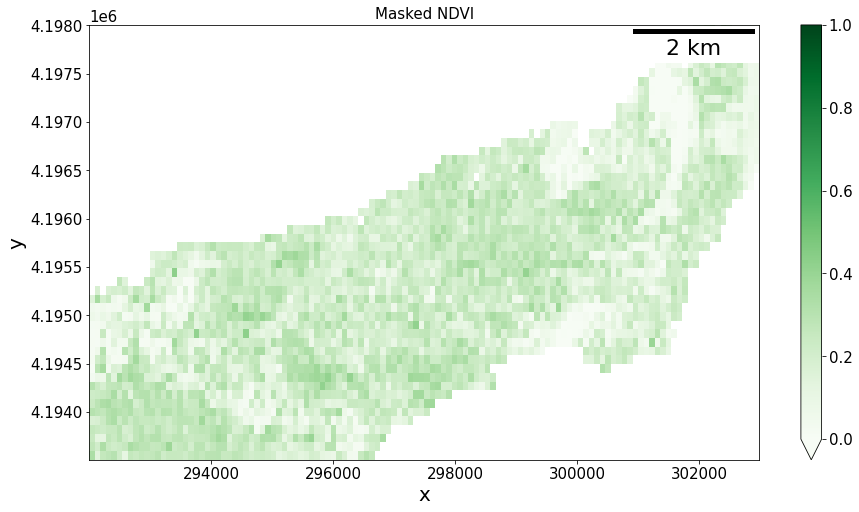

In [19]:
# Plot NDVI
f, ax = plt.subplots(figsize=(15,8))
NDVI.plot(ax=ax, vmin=0, vmax=1,cmap='Greens')
ax.add_artist(ScaleBar(1.0))
ax.set_title('Masked NDVI');

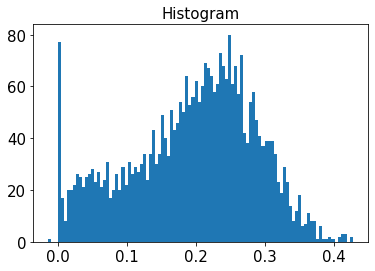

In [20]:
NDVI.plot.hist(bins=100);

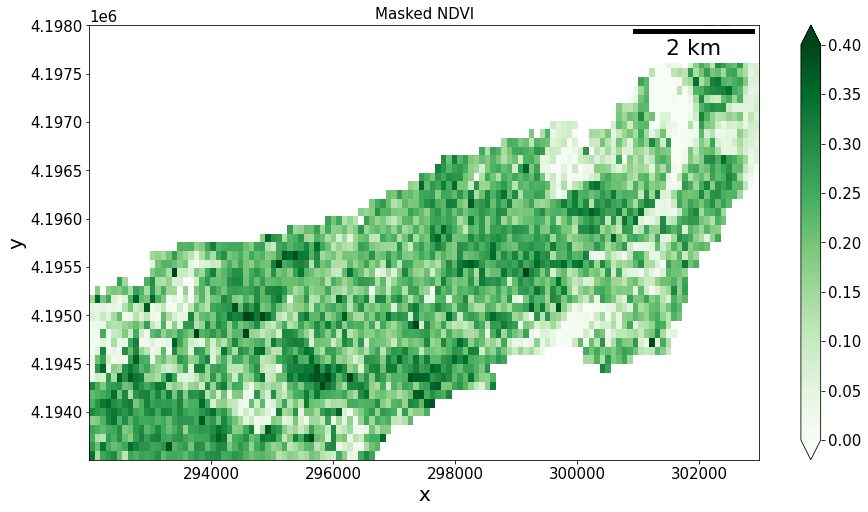

In [21]:
# Plot NDVI
f, ax = plt.subplots(figsize=(15,8))
NDVI.plot(ax=ax, vmin=0, vmax=0.4,cmap='Greens')
ax.add_artist(ScaleBar(1.0))
ax.set_title('Masked NDVI');

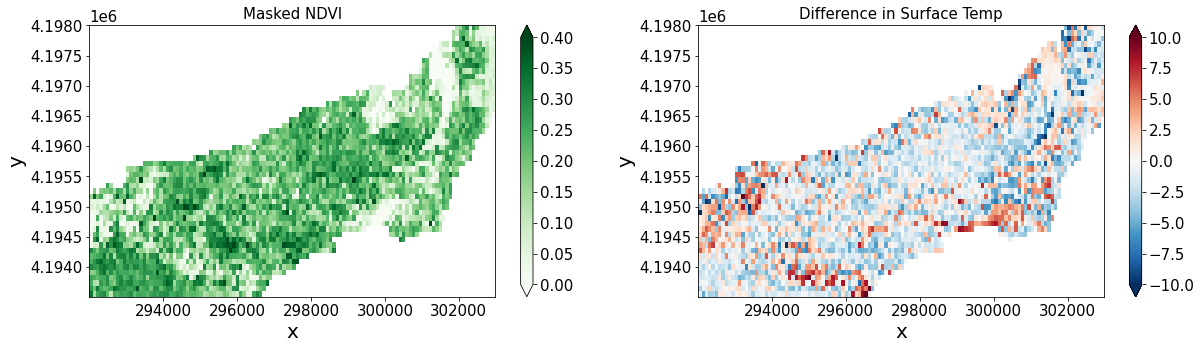

In [22]:
f, [ax1, ax2] = plt.subplots(1,2)

NDVI.plot(ax=ax1, vmin=0, vmax=.4, cmap='Greens')
ax1.set_title('Masked NDVI')
diff.plot(ax=ax2, vmin=-10, vmax=10, cmap='RdBu_r')
ax2.set_title('Difference in Surface Temp')

f.set_figwidth(20)
f.set_figheight(5);

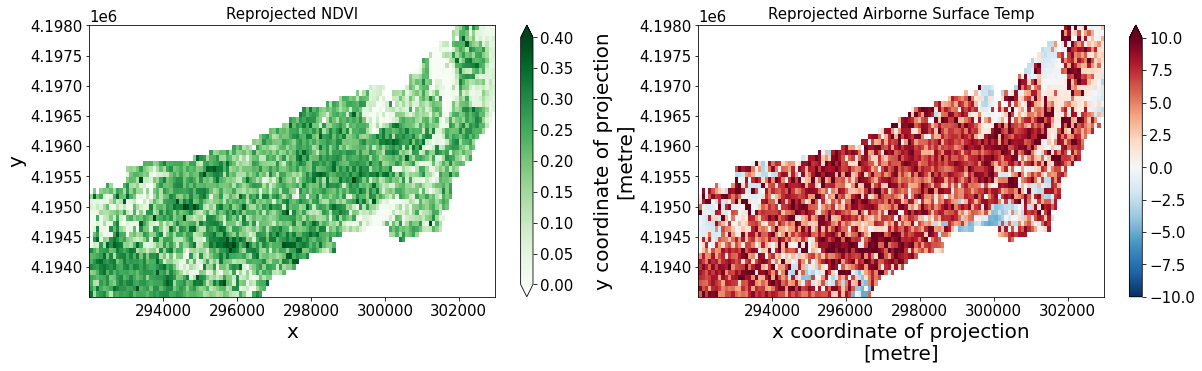

In [23]:
f, [ax1, ax2] = plt.subplots(1,2)

NDVI.plot(ax=ax1, vmin=0, vmax=.4, cmap='Greens')
ax1.set_title('Reprojected NDVI')
air_tb_repr.plot(ax=ax2, vmin=-10, vmax=10, cmap='RdBu_r')
ax2.set_title('Reprojected Airborne Surface Temp')

f.set_figwidth(20)
f.set_figheight(5);

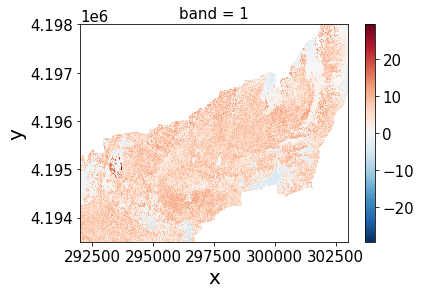

In [36]:
air_tb.plot()

In [68]:
min_lon = 294000
min_lat = 4194500
max_lon = 294180
max_lat = 4194760

air_clipped = air_tb.rio.clip_box(
    min_lon,
    min_lat,
    max_lon,
    max_lat,
)

ast_clipped = aster_tb_degC.rio.clip_box(
    min_lon,
    min_lat,
    max_lon,
    max_lat,
)

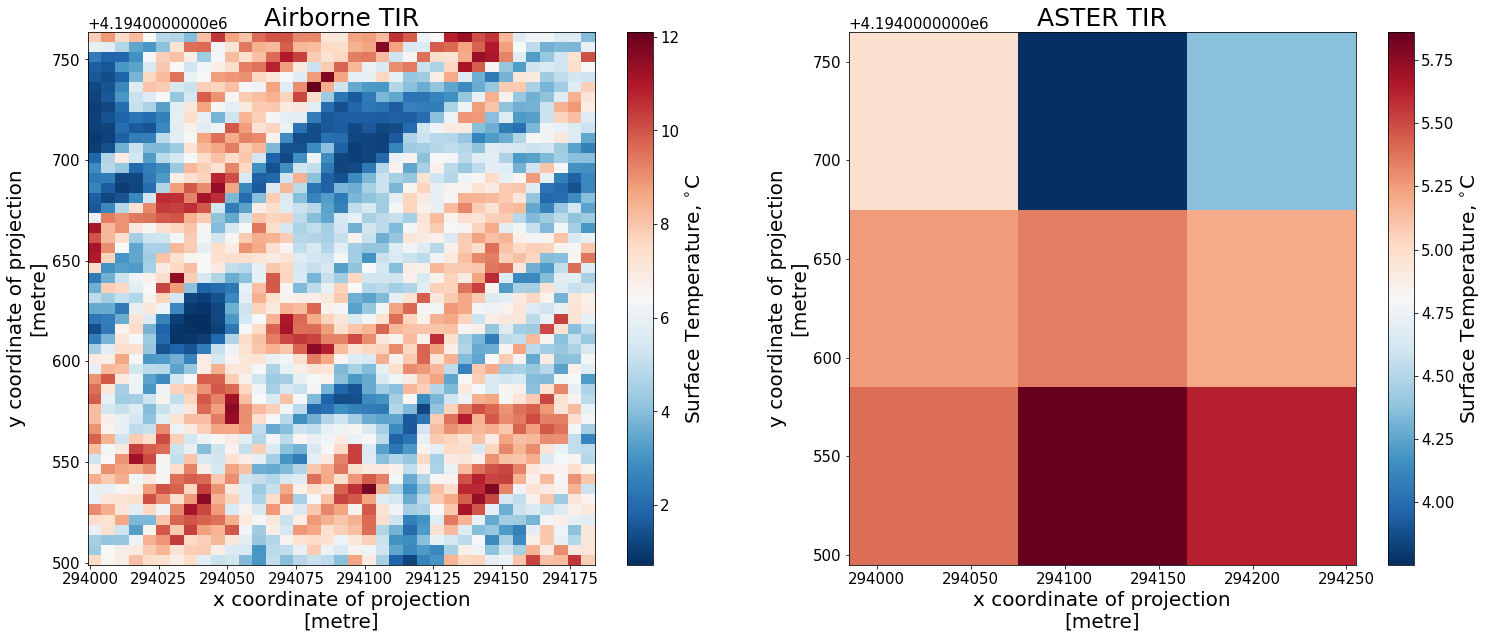

In [69]:
# Plot both datasets
f, ax = plt.subplots(1,2,figsize=(25,9.8))

air_clipped.plot(cmap='RdBu_r', cbar_kwargs={'label': 'Surface Temperature, $^{\circ}$C'},ax=ax[0])
#ax[0].add_artist(ScaleBar(1.0))
ax[0].set_title('Airborne TIR', fontsize=25)

ast_clipped.plot(cmap='RdBu_r', cbar_kwargs={'label': 'Surface Temperature, $^{\circ}$C'},ax=ax[1])
#ax[1].add_artist(ScaleBar(1.0))
ax[1].set_title('ASTER TIR', fontsize=25);

In [94]:
NDVI_m = NDVI.values[~np.isnan(NDVI.values)]
diff_m = diff.values[~np.isnan(diff.values)]

In [100]:
slope, intercept, rvalue, pvalue, stderr = stats.linregress(NDVI_m, diff_m)

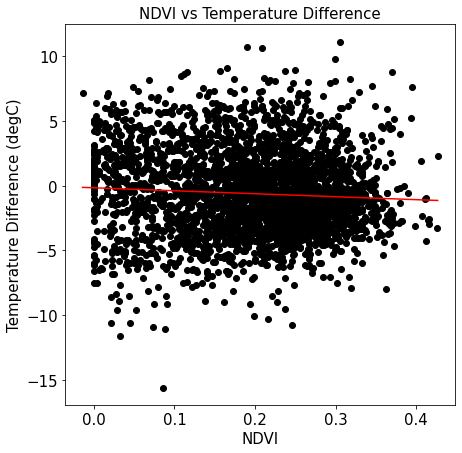

In [103]:
# Plot scatterplot
fig, ax = plt.subplots(figsize=(7,7))
plt.scatter(x=NDVI_m, y=diff_m, c='k');
ax.set_title('NDVI vs Temperature Difference')
ax.set_xlabel('NDVI', fontsize=15)
ax.set_ylabel('Temperature Difference (degC)', fontsize=15)

x = np.linspace(NDVI_m.min(), NDVI_m.max(), NDVI_m.size) # x coordinates from min and max values
y = slope * x + intercept 

# Plot the regression line
ax.plot(x, y, '-r')


In [104]:
print('R^2 = ', rvalue**2)

R^2 =  0.004182967196894952


In [105]:
print('Slope = ', slope)

Slope =  -2.2922376378341536


In [106]:
print('p-value = ', pvalue)

p-value =  0.00026863363082933967
